In [81]:
import os
import numpy as np
import scipy.misc as msc
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import plotly.plotly as py
import plotly.graph_objs as go

In [82]:
def read_images(folder, names):
    images = [msc.imread(folder + '/' + f) for f in names]
    return images
    
def read_names(folder):
    files = os.listdir(folder)
    return files

def flatten(images):
    X = np.stack(images, axis=0)
    shape = X.shape[1:]
    X = [image.flatten() for image in X]
    return X, shape

def to_dict(tuple):
    return dict([('image', tuple[0]), ('label', tuple[1])])

def positive(name):
    return 'Pos' in name

def negative(name):
    return 'Neg' in name

def label(names, index):
    return 1 if positive(names[index]) else -1

def draw(vector, shape):
    plt.figure()
    plt.imshow(np.reshape(vector, shape), 'gray')
    plt.axis('off')
    plt.show()
    
def normilize(img, shape):
    new_img = Image.fromarray(np.uint8(img))
    new_img = new_img.resize(shape[::-1])
    return np.asarray(new_img)


In [83]:
train_folder = '../uiucTrain'
train_names = read_names(train_folder)

In [84]:
train_images = read_images(train_folder, train_names)
train_images, shape = flatten(train_images)
train_images = [to_dict((image, label(train_names, index))) \
                for index, image in enumerate(train_images)]

X = [[], []]
for img in train_images:
    if img['label'] == 1:
        X[0].append(img['image'])
    else:
        X[1].append(img['image'])

X[0] = np.asarray(X[0])
X[1] = np.asarray(X[1])


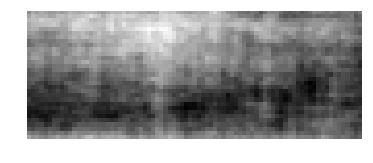

In [85]:
mean_vectors = []
for cl in range(2):
    mean_vectors.append(np.mean(X[cl], axis=0))
    
draw(mean_vectors[1], shape)

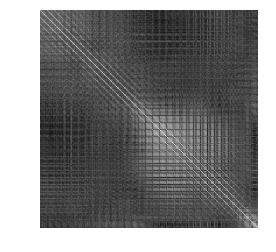

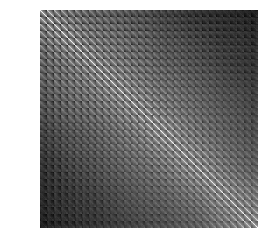

('within-class Scatter Matrix:\n', array([[ 14181266.8155531 ,  13023200.27207999,  12048700.19568831, ...,
          1214576.87589496,   1071219.83575071,    991224.94309265],
       [ 13023200.27207999,  13713919.99675695,  12915859.07273913, ...,
          1188355.57394124,   1006759.49062112,    974624.78909408],
       [ 12048700.19568831,  12915859.07273913,  13965419.1393556 , ...,
          1209549.88632401,   1039935.58409289,    968341.92200999],
       ..., 
       [  1214576.87589496,   1188355.57394124,   1209549.88632401, ...,
         14046415.6297918 ,  13130077.36964678,  12195993.97574702],
       [  1071219.83575071,   1006759.49062112,   1039935.58409289, ...,
         13130077.36964678,  14069860.76106313,  13285052.6466672 ],
       [   991224.94309265,    974624.78909408,    968341.92200999, ...,
         12195993.97574702,  13285052.6466672 ,  14198038.08829361]]))


In [86]:
size = shape[0] * shape[1]

S_W = np.zeros((size, size))
for cl, mv in zip(range(2), mean_vectors):
    class_sc_mat = np.zeros((size, size))                  # scatter matrix for every class
    for row in X[cl]:
        row, mv = row.reshape(size, 1), mv.reshape(size, 1) # make column vectors
        class_sc_mat += (row-mv).dot((row-mv).T)
    draw(class_sc_mat, (size, size))
    S_W += class_sc_mat                             # sum class scatter matrices
print('within-class Scatter Matrix:\n', S_W)

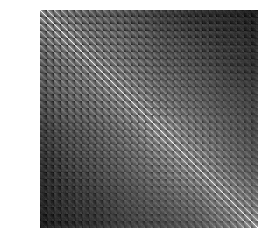

In [7]:
draw(S_W, (size, size))

('between-class Scatter Matrix:\n', array([[  3101.34228011,   5310.07320449,   3966.7828775 , ...,
         -6974.33809293,  -9152.66973356, -11382.46998275],
       [  5310.07320449,   9091.83021102,   6791.86802467, ...,
        -11941.36037928, -15671.06817373, -19488.89977218],
       [  3966.7828775 ,   6791.86802467,   5073.72775271, ...,
         -8920.55195144, -11706.75478658, -14558.78872861],
       ..., 
       [ -6974.33809293, -11941.36037928,  -8920.55195144, ...,
         15683.98049657,  20582.64048573,  25597.04373857],
       [ -9152.66973356, -15671.06817373, -11706.75478658, ...,
         20582.64048573,  27011.32467344,  33591.90282618],
       [-11382.46998275, -19488.89977218, -14558.78872861, ...,
         25597.04373857,  33591.90282618,  41775.66073215]]))


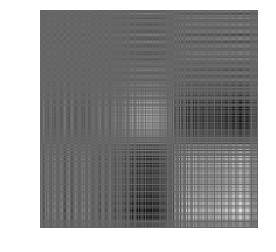

In [8]:
overall_mean = np.mean(np.concatenate((X[0], X[1]), axis=0), axis=0)

S_B = np.zeros((size, size))
for i, mean_vec in enumerate(mean_vectors):  
    n = len(X[i])
    mean_vec = mean_vec.reshape(size, 1) # make column vector
    overall_mean = overall_mean.reshape(size, 1) # make column vector
    S_B += n * (mean_vec - overall_mean).dot((mean_vec - overall_mean).T)

print('between-class Scatter Matrix:\n', S_B)
draw(S_B, (size, size))

In [9]:
eig_vals, eig_vecs = np.linalg.eig(np.linalg.inv(S_W).dot(S_B))

for i in range(len(eig_vals)):
    eigvec_sc = eig_vecs[:,i].reshape(size, 1)   
    print('\nEigenvector {}: \n{}'.format(i+1, eigvec_sc.real))
    print('Eigenvalue {:}: {:.2e}'.format(i+1, eig_vals[i].real))


Eigenvector 1: 
[[ 0.0039647 ]
 [-0.01462221]
 [ 0.01145554]
 ..., 
 [ 0.01758596]
 [-0.01514036]
 [ 0.00876702]]
Eigenvalue 1: 3.58e+02

Eigenvector 2: 
[[ 0.0010001 ]
 [-0.02080618]
 [-0.01473073]
 ..., 
 [-0.01238449]
 [ 0.00763904]
 [-0.00589431]]
Eigenvalue 2: 4.21e-12

Eigenvector 3: 
[[ 0.0010001 ]
 [-0.02080618]
 [-0.01473073]
 ..., 
 [-0.01238449]
 [ 0.00763904]
 [-0.00589431]]
Eigenvalue 3: 4.21e-12

Eigenvector 4: 
[[ 0.00805364]
 [ 0.00047567]
 [ 0.00361826]
 ..., 
 [ 0.02932729]
 [-0.02635511]
 [ 0.00323698]]
Eigenvalue 4: -3.98e-12

Eigenvector 5: 
[[-0.00213521]
 [-0.03369264]
 [ 0.00138651]
 ..., 
 [-0.02481159]
 [ 0.03213376]
 [ 0.00213725]]
Eigenvalue 5: -3.29e-12

Eigenvector 6: 
[[-0.00213521]
 [-0.03369264]
 [ 0.00138651]
 ..., 
 [-0.02481159]
 [ 0.03213376]
 [ 0.00213725]]
Eigenvalue 6: -3.29e-12

Eigenvector 7: 
[[-0.04108885]
 [ 0.1893486 ]
 [ 0.00205161]
 ..., 
 [ 0.00678963]
 [ 0.01482089]
 [-0.00128573]]
Eigenvalue 7: 3.38e-12

Eigenvector 8: 
[[-0.04108885]

In [10]:
eigvec_sc = eig_vecs[:,0].reshape(size, 1).real

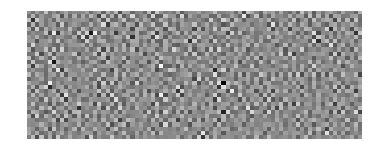

[-0.54739121]
[ 0.45260879]
[ 0.15549341]


In [13]:
draw(eigvec_sc, shape)
w = eigvec_sc
print min(w) / (max(w) - min(w))
print max(w) / (max(w) - min(w))
print max(w) - min(w)

In [14]:
# Make a list of (eigenvalue, eigenvector) tuples
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eig_pairs = sorted(eig_pairs, key=lambda k: k[0], reverse=True)

# Visually confirm that the list is correctly sorted by decreasing eigenvalues

print('Eigenvalues in decreasing order:\n')
for i in eig_pairs:
    print(i[0])

Eigenvalues in decreasing order:

358.34343243
5.90796751733e-12
5.90796751733e-12
3.977089862e-12
3.43343553822e-12
3.43343553822e-12
3.4286330191e-12
3.4286330191e-12
2.9513224157e-12
2.91872286078e-12
2.91872286078e-12
2.74079221579e-12
2.74079221579e-12
2.73424174144e-12
2.73424174144e-12
2.73083019877e-12
2.73083019877e-12
2.67878069727e-12
2.62741762929e-12
2.62741762929e-12
2.50107854373e-12
2.50107854373e-12
2.48925557299e-12
2.48925557299e-12
2.31520264157e-12
2.31520264157e-12
2.29589250484e-12
2.29589250484e-12
2.19319997531e-12
2.19319997531e-12
2.18111008335e-12
2.18111008335e-12
2.13902152675e-12
2.13902152675e-12
2.0070334616e-12
2.0070334616e-12
1.92807778403e-12
1.92807778403e-12
1.91386632838e-12
1.88031259292e-12
1.88031259292e-12
1.87598197161e-12
1.84971249487e-12
1.84971249487e-12
1.81262945e-12
1.81262945e-12
1.81094149957e-12
1.81094149957e-12
1.71451324962e-12
1.71451324962e-12
1.70691947455e-12
1.70691947455e-12
1.683809677e-12
1.683809677e-12
1.67409676183e-1

In [15]:
print('Variance explained:\n')
eigv_sum = sum(eig_vals)
for i,j in enumerate(eig_pairs):
    print('eigenvalue {0:}: {1:.2%}'.format(i+1, (j[0]/eigv_sum).real))

Variance explained:

eigenvalue 1: 100.00%
eigenvalue 2: 0.00%
eigenvalue 3: 0.00%
eigenvalue 4: 0.00%
eigenvalue 5: 0.00%
eigenvalue 6: 0.00%
eigenvalue 7: 0.00%
eigenvalue 8: 0.00%
eigenvalue 9: 0.00%
eigenvalue 10: 0.00%
eigenvalue 11: 0.00%
eigenvalue 12: 0.00%
eigenvalue 13: 0.00%
eigenvalue 14: 0.00%
eigenvalue 15: 0.00%
eigenvalue 16: 0.00%
eigenvalue 17: 0.00%
eigenvalue 18: 0.00%
eigenvalue 19: 0.00%
eigenvalue 20: 0.00%
eigenvalue 21: 0.00%
eigenvalue 22: 0.00%
eigenvalue 23: 0.00%
eigenvalue 24: 0.00%
eigenvalue 25: 0.00%
eigenvalue 26: 0.00%
eigenvalue 27: 0.00%
eigenvalue 28: 0.00%
eigenvalue 29: 0.00%
eigenvalue 30: 0.00%
eigenvalue 31: 0.00%
eigenvalue 32: 0.00%
eigenvalue 33: 0.00%
eigenvalue 34: 0.00%
eigenvalue 35: 0.00%
eigenvalue 36: 0.00%
eigenvalue 37: 0.00%
eigenvalue 38: 0.00%
eigenvalue 39: 0.00%
eigenvalue 40: 0.00%
eigenvalue 41: 0.00%
eigenvalue 42: 0.00%
eigenvalue 43: 0.00%
eigenvalue 44: 0.00%
eigenvalue 45: 0.00%
eigenvalue 46: 0.00%
eigenvalue 47: 0.00%

In [16]:
W = np.hstack((eig_pairs[0][1].reshape(size,1)))
print('Matrix W:\n', W.real)

('Matrix W:\n', array([ 0.0039647 , -0.01462221,  0.01145554, ...,  0.01758596,
       -0.01514036,  0.00876702]))


In [17]:
X_lda = []

In [18]:
X_lda.append(X[0].dot(W))
X_lda.append(X[1].dot(W))

In [19]:
W.shape

(2511,)

In [20]:
w = W.real

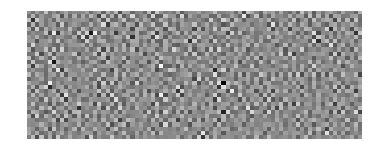

In [21]:
draw(w, shape)

In [42]:
mu = []
print([np.dot(w.T, mean_vectors[0]), np.dot(w.T, mean_vectors[1])])
# mu.append(np.dot(w.T, mean_vectors[0]))
# mu.append(np.dot(w.T, mean_vectors[1]))
mu_pos = 0
for v in X[0]:
    mu_pos += np.dot(w, v) 
mu_pos /= len(X[0])
# mu_pos = np.dot(w, mean_pos) / len(pos)

mu_neg = 0
for v in X[1]:
    mu_neg += np.dot(w, v)
mu_neg /= len(X[1])
# mu_neg = np.dot(w, mean_neg) / len(neg)
# print mu_pos
# print mu_neg
mu.append(mu_pos)
mu.append(mu_neg)

[10.25455339200694, -0.33454371434355323]


In [43]:
mu

[10.254553392006907, -0.33454371434375013]

In [70]:
classifiers = []
tettas = []
def classifier(mu1, mu2, index, total, w):
    delimeter = (total - 1) # total + 1
    tetta = mu1 + abs(float(mu2 - mu1)) / (total - 1) * (index) # index + 1
    tettas.append(tetta)
    def cl(x):
        if np.dot(w, x) >= tetta:
            return 1
        return -1
    return cl

cl_number = 10
for index in range(cl_number):
    classifiers.append(classifier(mu[1], mu[0], index, cl_number, w))

In [64]:
pr = []
rec = []
for cl in classifiers:
    true_pos = 0
    false_neg = 0
    for im in X[0]:
        if cl(im) != 1:
            false_neg += 1
        else:
            true_pos += 1
    
    true_neg = 0
    false_pos = 0
    for im in X[1]:
        if cl(im) != -1:
            false_pos += 1
        else:
            true_neg += 1
    # print float(errors_pos) / len(pos), float(errors_neg) / len(neg), float(errors_pos + errors_neg)/(len(neg) + len(pos))
    pr.append(float(true_pos) / (true_pos + false_pos))
    rec.append(float(true_pos) / (true_pos + false_neg))

In [55]:
the_cl = classifiers[5]

In [65]:
test_folder = '../uiucTest'
test_names = read_names(test_folder)

test_images = read_images(test_folder, test_names)
test_images = [normilize(img, shape) for img in test_images]
test_images, _ = flatten(test_images)
total_test = len(test_images)
for cl in classifiers:
    correct = 0
    for img in test_images:
        if cl(img) == 1:
            correct += 1
    print float(correct) / total_test

0.470588235294
0.464705882353
0.447058823529
0.423529411765
0.405882352941
0.405882352941
0.370588235294
0.347058823529
0.329411764706
0.305882352941


In [66]:
pr

[0.0924683072334079, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

In [67]:
rec

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.49193548387096775]

In [31]:
false_pos

0

In [32]:
false_neg

0

In [33]:
true_neg

2442

In [35]:
true_pos

124

In [68]:
for img in test_images:
    print np.dot(w, img)

-16.1802882314
60.8402675888
-10.1426531794
6.1308718265
-0.615788852301
-27.4959007221
43.7451869546
-30.3161991352
-11.3345923465
-1.83897275114
5.73767151677
37.0265773319
13.9243646046
-56.2664799019
-6.39615815854
8.45133716998
33.4145849604
-6.68707525326
-3.69489777771
2.69436090225
10.1971399421
7.04953486555
3.50955335452
16.0467715234
-16.6053240169
34.8748865974
-22.7223354179
38.0338616394
8.64262453442
12.5751369652
22.1152060334
-38.0306561041
-9.81807514693
-56.4838325326
-41.5420313564
-13.995208342
34.5819171482
16.5141866341
-46.3568641778
12.5995308546
-12.6152099365
3.40356971591
-11.5322005601
-10.390312603
13.7513693465
-16.4784291599
-8.55786146213
-24.6532365187
18.1583875176
-55.9242174469
26.2991766495
19.7333454391
1.64717145569
-8.56927922223
-53.9566444523
-2.43232710843
-20.6003757367
16.923606197
-18.5361486365
-46.0104784158
-15.7962954384
11.5194358678
-33.7703578886
21.1052559791
-1.26632580755
-6.84001751776
13.6993400633
-0.103700370435
-15.926710717

In [37]:
mu

[10.25455339200694, -0.33454371434355323]

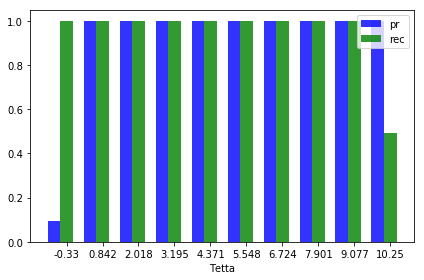

In [80]:
n_groups = cl_number
 
# create plot
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.8
 
rects1 = plt.bar(index, pr, bar_width,
                 alpha=opacity,
                 color='b',
                 label='pr')
 
rects2 = plt.bar(index + bar_width, rec, bar_width,
                 alpha=opacity,
                 color='g',
                 label='rec')
 
plt.xlabel('Tetta')
plt.ylabel('')
plt.title('')
plt.xticks(index + bar_width, [str(tetta)[:5] for tetta in tettas])
plt.legend()
 
plt.tight_layout()
plt.show()

In [77]:
str(tettas[0])[:5]

'-0.33'

In [87]:
len(X[0])

124

In [88]:
len(X[1])

2442

In [89]:
X[1][0].shape

(2511,)

In [90]:
shape

(31, 81)

In [91]:
len(test_images)

170

In [92]:
len(test_names)

170